In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import ipywidgets as widgets
from IPython.display import display

In [3]:
#Load the uploaded dataset
file_path = "CAR DETAILS FROM CAR DEKHO.csv"
df = pd.read_csv(file_path)

# Display basic information and first few rows
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


(None,
                        name  year  selling_price  km_driven    fuel  \
 0             Maruti 800 AC  2007          60000      70000  Petrol   
 1  Maruti Wagon R LXI Minor  2007         135000      50000  Petrol   
 2      Hyundai Verna 1.6 SX  2012         600000     100000  Diesel   
 3    Datsun RediGO T Option  2017         250000      46000  Petrol   
 4     Honda Amaze VX i-DTEC  2014         450000     141000  Diesel   
 
   seller_type transmission         owner  
 0  Individual       Manual   First Owner  
 1  Individual       Manual   First Owner  
 2  Individual       Manual   First Owner  
 3  Individual       Manual   First Owner  
 4  Individual       Manual  Second Owner  )

In [ ]:
df['brand'] = df['name'].apply(lambda x: x.split()[0])
df.drop('name', axis=1, inplace=True)

In [5]:
#Encode Categorical Variables
categorical_cols = ['fuel', 'seller_type', 'transmission', 'owner', 'brand']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

KeyError: 'brand'

In [6]:
#Define Features and Target
X = df.drop('selling_price', axis=1)
y = df['selling_price']

In [7]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#Train Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {'MAE': mae, 'RMSE': rmse}

print("Model Evaluation:\n", results)#

ValueError: could not convert string to float: 'Mahindra Scorpio S11 BSIV'

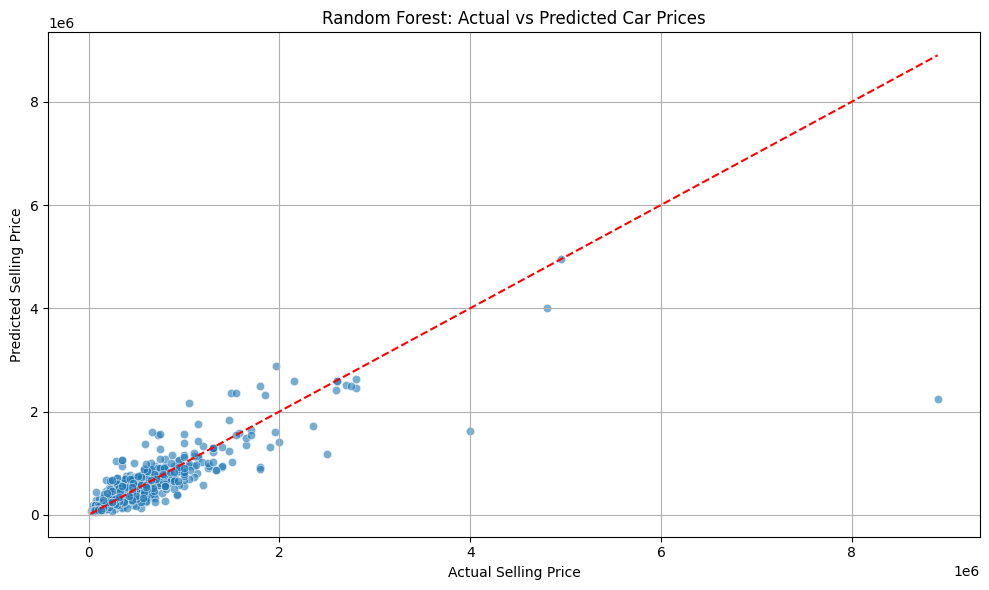

['random_forest_car_price_model.pkl']

In [ ]:
 #Plot Actual vs Predicted (Random Forest)
best_model = models['Random Forest']
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Random Forest: Actual vs Predicted Car Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

#Save the Best Model
joblib.dump(best_model, "random_forest_car_price_model.pkl")

In [9]:
# Install Gradio in Colab
!pip install -q gradio

import pandas as pd
import numpy as np
import gradio as gr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("CAR DETAILS FROM CAR DEKHO.csv")

# Simplify car name to brand
df['brand'] = df['name'].apply(lambda x: x.split()[0])
df.drop('name', axis=1, inplace=True)

# Encode categorical variables
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner', 'brand']
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Features and target
X = df.drop('selling_price', axis=1)
y = df['selling_price']

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Define prediction function
def predict_price(year, km_driven, fuel, seller_type, transmission, owner, brand):
    # Encode inputs
    fuel_encoded = encoders['fuel'].transform([fuel])[0]
    seller_encoded = encoders['seller_type'].transform([seller_type])[0]
    trans_encoded = encoders['transmission'].transform([transmission])[0]
    owner_encoded = encoders['owner'].transform([owner])[0]
    brand_encoded = encoders['brand'].transform([brand])[0]

    # Create DataFrame for prediction
    input_df = pd.DataFrame([[year, km_driven, fuel_encoded, seller_encoded,
                              trans_encoded, owner_encoded, brand_encoded]],
                            columns=X.columns)

    # Predict
    price = model.predict(input_df)[0]
    return f"Estimated Selling Price: ₹{int(price):,}"

# Get list of categories
fuel_list = encoders['fuel'].classes_.tolist()
seller_list = encoders['seller_type'].classes_.tolist()
trans_list = encoders['transmission'].classes_.tolist()
owner_list = encoders['owner'].classes_.tolist()
brand_list = sorted(encoders['brand'].classes_.tolist())

# Gradio interface
interface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="Year of Manufacture", value=2015),
        gr.Number(label="Kilometers Driven", value=50000),
        gr.Dropdown(fuel_list, label="Fuel Type"),
        gr.Dropdown(seller_list, label="Seller Type"),
        gr.Dropdown(trans_list, label="Transmission"),
        gr.Dropdown(owner_list, label="Owner Type"),
        gr.Dropdown(brand_list, label="Car Brand")
    ],
    outputs=gr.Textbox(label="Predicted Price"),
    title="Used Car Price Predictor",
    description="Enter details to predict the resale price of your car."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://93e68d339563530ee9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
